In [23]:
#import all
import sys
sys.path.append("../lib")
from tqdm import tqdm

import numpy as np
import healpy as hp
import pymaster as nmt 
import pysm3
import time
from mpfit import mpfit
import mpfitlib as mpl
import scipy
#from Nearest_Positive_Definite import *
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patheffects as path_effects
import scipy.stats as st
import basicfunc as func
import analys_lib as an
import simu_lib as sim
import pysm3.units as u

#sim params

r = 0
nside = 16
Npix = hp.nside2npix(nside)
N=100 
lmax = nside*3-1
#lmax=850
scale = 10
Nlbin = 10
fsky = 0.7
dusttype = 0
syncrotype = 0
kw = ''
load=True


# instr param

ifreq=[0,9,21]
instr_name='litebird_full'
instr =  np.load("../lib/instr_dict/%s.npy"%instr_name,allow_pickle=True).item()
freq= instr['frequencies']
sens_P= instr['sens_P']
freq=freq[ifreq]
sens_P=sens_P[ifreq]
sigpix= sens_P/(np.sqrt((4*np.pi)/Npix*(60*180/np.pi)**2))
b = nmt.bins.NmtBin(nside=nside,lmax=lmax,nlb=Nlbin)
leff = b.get_effective_ells()
N_freqs =len(freq)
Ncross=int(N_freqs*(N_freqs+1)/2)

nucross = []
for i in range(0,N_freqs):
    for j in range(i,N_freqs):
        nucross.append(np.sqrt(freq[i]*freq[j]))
nucross = np.array(nucross)


#cmb
CLcmb_or=hp.read_cl('../CLsimus/Cls_Planck2018_r0.fits') #TT EE BB TE
DL_lens = leff*(leff+1)*b.bin_cell(CLcmb_or[2,2:lmax+3])/2/np.pi

#mask

mask = hp.read_map("../masks/mask_fsky%s_nside%s_aposcale%s.npy"%(fsky,nside,scale))

#np.save("./test-sim-cov/map-test/mapfg.npy",mapfg)

# call cmb
#call foreground sky
if dusttype==None and syncrotype==None:
    mapfg=np.zeros((N_freqs,2,Npix))
else:
    if dusttype==None:
        sky = pysm3.Sky(nside=512, preset_strings=['s%s'%syncrotype])#,'s%s'%synctype])
    if syncrotype==None:
    	sky = pysm3.Sky(nside=512, preset_strings=['d%s'%dusttype])#,'s%s'%synctype])
    if syncrotype!=None and dusttype!=None:
    	sky = pysm3.Sky(nside=512, preset_strings=['d%s'%dusttype,'s%s'%syncrotype])
    mapfg= np.array([sim.downgrade_map(sky.get_emission(freq[f] * u.GHz).to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freq[f]*u.GHz)),nside_in=512,nside_out=nside) for f in range(len(freq))])
    mapfg=mapfg[:,1:]


In [24]:
# create N sims
mapcmb = np.zeros((N,N_freqs,2,Npix))

for k in tqdm(range(0,N)):
    mapcmb0= hp.synfast(CLcmb_or,nside,pixwin=False,new=True)
    mapcmb1 = np.array([mapcmb0 for i in range(N_freqs)])
    mapcmb[k] = mapcmb1[:,1:]


100%|██████████| 100/100 [00:00<00:00, 1632.02it/s]


In [25]:
# compute the spectra of N2 sims
N2=100

#workspace
wsp_dc=[]
for i in range(0,N_freqs): 
    for j in range(i,N_freqs):
        w_dc = nmt.NmtWorkspace()
        if i != j :
            w_dc.compute_coupling_matrix(nmt.NmtField(mask, 1*mapfg[i],purify_e=False, purify_b=True), nmt.NmtField(mask,1*mapfg[j],purify_e=False, purify_b=True), b)
        if i==j :
            w_dc.compute_coupling_matrix(nmt.NmtField(mask, 1*mapfg[i],purify_e=False, purify_b=True), nmt.NmtField(mask, 1*mapfg[j],purify_e=False, purify_b=True), b)
        wsp_dc.append(w_dc)
 
wsp_dc=np.array(wsp_dc)

def computecross(mapauto1,mapauto2,mapcross1,mapcross2):
    CLcross=np.zeros((Ncross,len(leff)))
    z=0
    for i in range(0,N_freqs):
        for j in range(i,N_freqs):
            if i != j :
                CLcross[z]=np.array((sim.compute_master(nmt.NmtField(mask, 1*mapauto1[i],purify_e=False, purify_b=True), nmt.NmtField(mask, 1*mapauto2[j],purify_e=False, purify_b=True), wsp_dc[z]))[3])
            if i==j :
                CLcross[z]=np.array((sim.compute_master(nmt.NmtField(mask, 1*mapcross1[i],purify_e=False, purify_b=True), nmt.NmtField(mask, 1*mapcross2[j],purify_e=False, purify_b=True), wsp_dc[z]))[3])
            z = z +1
    return leff*(leff+1)*CLcross/2/np.pi

DLcross_cmb= np.zeros((N2,Ncross,len(leff)))

for k in tqdm(range(0,N2)):
    #addition du bruit aux cartes
    DLcross_cmb[k]= computecross(mapcmb[k],mapcmb[k],mapcmb[k],mapcmb[k])

100%|██████████| 100/100 [00:07<00:00, 13.68it/s]


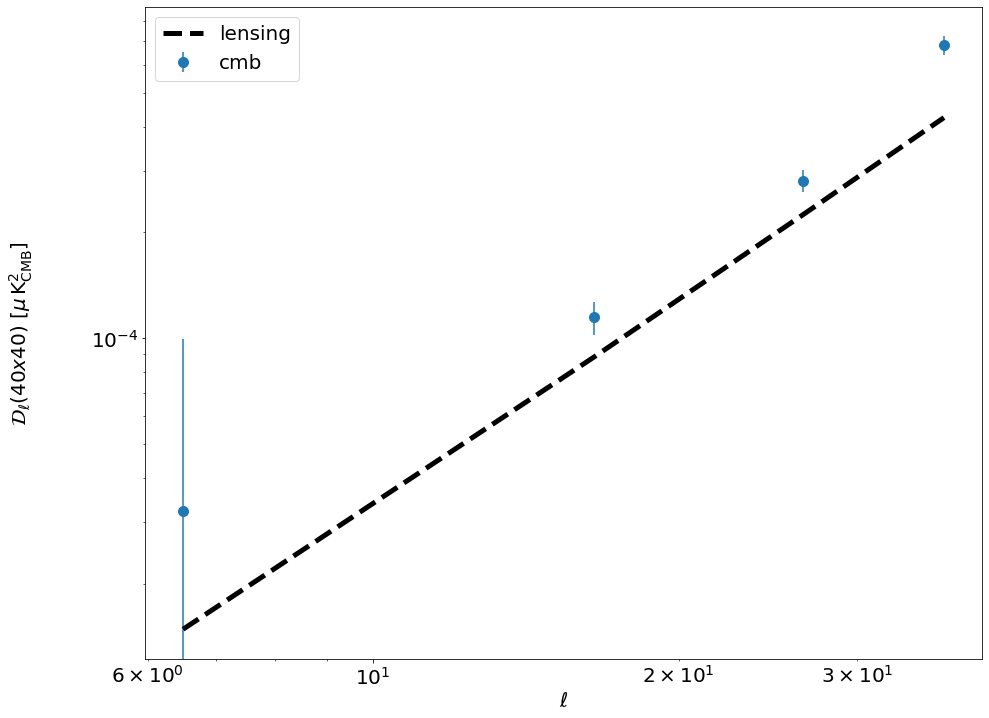

In [26]:
f=0
nucrosslabel = []
for i in range(0,N_freqs):
    for j in range(i,N_freqs):
        nucrosslabel.append('%sx%s'%(freq[i],freq[j]))
nucrosslabel = np.array(nucrosslabel)

font = {'size': 20}
matplotlib.rc('font', **font)
cmap   = plt.get_cmap('jet_r',402) #color map parameter
plt.figure(figsize=(15,12))

def ploterrbar(l,DL,legend):
    DL_mean=np.mean(DL, axis=0)
    DL_std=np.std(DL, axis=0)
    plt.errorbar(l,DL_mean[int(f)],yerr=DL_std[int(f)],fmt='.',markersize=20,label=legend)

#ploterrbar(leff,DLcross_coadd,legend='coadd')
ploterrbar(leff,DLcross_cmb,legend='cmb')
#plt.plot(leff, DLcross_fg[f], color='black', linestyle = '--', lw=5, label='fg',zorder=90)
plt.plot(leff, DL_lens, color='black', linestyle = '--', lw=5, label='lensing',zorder=90)
plt.legend()
tick = 45/3
plt.loglog()
plt.ylabel(r"$\mathcal{D}_\ell(%s) \, \,  [\mu \,{\rm K}_{\rm CMB}^2]$"%nucrosslabel[f],labelpad=56)
plt.xlabel(r'$\ell$')
plt.show()